In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import seaborn as sns
from tqdm import tqdm

from network_classes import MNIST_net

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 15,
                     'axes.spines.right': False,
                     'axes.spines.top': False,
                     'axes.linewidth':1.2,
                     'xtick.major.size': 6,
                     'xtick.major.width': 1.2,
                     'ytick.major.size': 6,
                     'ytick.major.width': 1.2,
                     'legend.frameon': False,
                     'legend.handletextpad': 0.1,
                     'figure.figsize': [14.0, 4.0],})

In [2]:
tensor_normalize = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.1307],std=[0.3081])])

MNIST_train = torchvision.datasets.MNIST(root='MNIST_data/',train=True,transform=tensor_normalize,download=False)
MNIST_test = torchvision.datasets.MNIST(root='MNIST_data/',train=False,transform=tensor_normalize,download=False)

batch_size = 32
dataloader = torch.utils.data.DataLoader(MNIST_train,
                                         batch_size=batch_size,
                                         shuffle=True)

dataloader_test = torch.utils.data.DataLoader(MNIST_test,
                                              batch_size=10000,
                                              shuffle=True)

In [3]:
MNIST_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.1307], std=[0.3081])
           )

In [4]:
# # Calculate mean and std of dataset
# all_images = torch.zeros(len(dataloader),784)

# for i,(image,label) in enumerate(dataloader):
#     all_images[i] = image.flatten()

# print(torch.mean(all_images))
# print(torch.std(all_images))

Label = 1
torch.Size([32, 1, 28, 28])


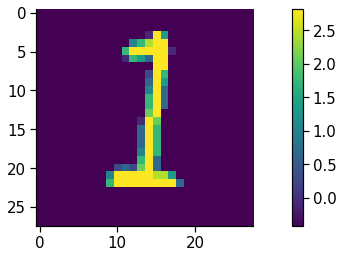

In [5]:
# Print example image

# inputs, classes = next(iter(dataloader))   
# plt.imshow(inputs[0,0,:,:])
for image, label in dataloader:
    plt.imshow(image[0,0])
    plt.colorbar()
    print(f'Label = {label[0]}')
    print(image.shape)
    break

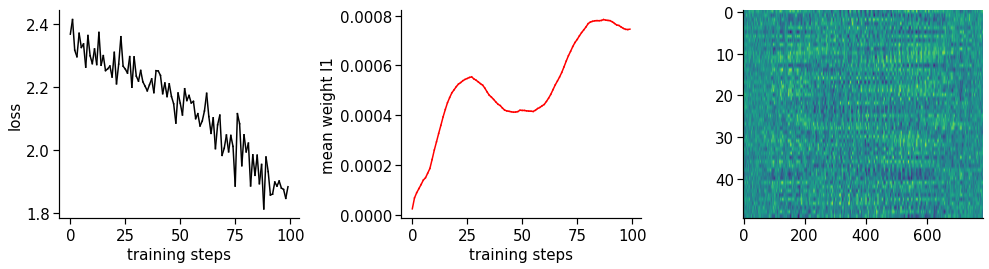

Final accuracy = 62.779998779296875%


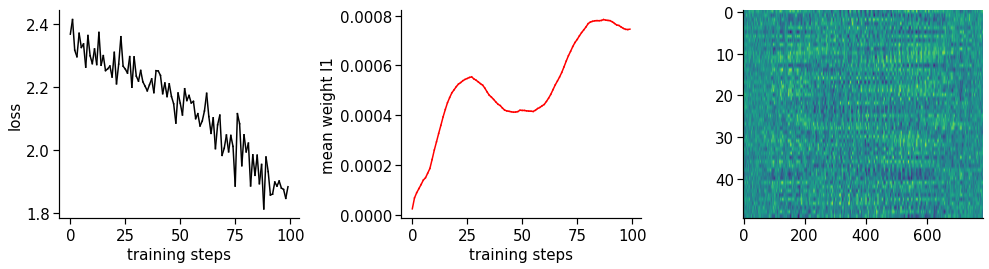

In [6]:
torch.manual_seed(123)

model = MNIST_net(batch_size, dales_law=False)
model.train(dataloader,
            dataloader_test,
            num_epochs = 1,
            max_batch = 100,
            lr = 0.0005,
            plot_dynamic_loss=True)

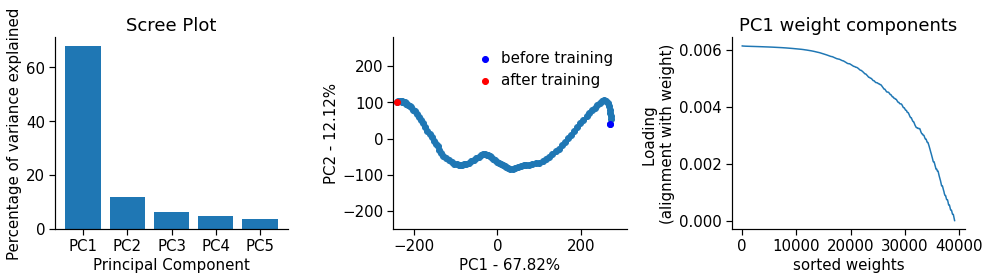

In [7]:
# PCA of the weight space
from sklearn.decomposition import PCA

w1 = model.weight_history1.flatten(start_dim=1)
w1_mean = torch.mean(w1, axis=0)
w1_std = torch.std(w1, axis=0)
w1 = (w1 - w1_mean) / w1_std # center the data (mean=0, std=1)
pca = PCA(n_components=5)
pca.fit(w1)
w1_pca = pca.transform(w1)

# Plot explained variance
fig, ax = plt.subplots(1,3)
explained_variance = pca.explained_variance_ratio_
percent_exp_var = np.round(explained_variance*100,decimals=2)
labels = ['PC' + str(x) for x in range(1,len(percent_exp_var)+1)]
ax[0].bar(x=range(1,len(percent_exp_var)+1), height=percent_exp_var, tick_label=labels)
ax[0].set_ylabel('Percentage of variance explained')
ax[0].set_xlabel('Principal Component')
ax[0].set_title('Scree Plot')

# Plot weights in PC space
PC1 = w1_pca[:,0]
PC2 = w1_pca[:,1]
ax[1].scatter(PC1,PC2)
ax[1].scatter(PC1[0],PC2[0],color='blue',label='before training')
ax[1].scatter(PC1[-1],PC2[-1],color='red',label='after training')
ax[1].set_xlabel(f'PC1 - {percent_exp_var[0]}%')
ax[1].set_ylabel(f'PC2 - {percent_exp_var[1]}%')
ax[1].legend()
ax[1].set_ylim([-250,280])
ax[1].set_xlim([-250,310])


# Plot loading scores for PC1 to determine which/how many weights are important for variance along PC1
sorted_loadings = -np.sort(-np.abs(pca.components_[0])) # Loadings sorted in descending order of abs magnitude
sorted_idx = np.argsort(-np.abs(pca.components_[0]))

most_important_weights_flat = sorted_idx[0:10] #
most_important_weights_idx = [] # index of important weights in original weight matrix

ax[2].plot(sorted_loadings)
ax[2].set_xlabel('sorted weights')
ax[2].set_ylabel('Loading \n(alignment with weight)')
ax[2].set_title('PC1 weight components')

plt.tight_layout()
plt.show()

In [11]:
# Get weights in gridplane defined by PC dimensions
pca = PCA(n_components=2)
pca.fit(w1)

num_points = 20
delta_PC1 = np.max(PC1) - np.min(PC1)
delta_PC2 = np.max(PC2) - np.min(PC2)
range_extension = 0.2
PC1_range = np.linspace(np.min(PC1)-delta_PC1*range_extension, np.max(PC1)+delta_PC1*range_extension, num_points)
PC2_range = np.linspace(np.min(PC2)-delta_PC2*range_extension, np.max(PC2)+delta_PC2*range_extension, num_points)

PC1_mesh, PC2_mesh = np.meshgrid(PC1_range,PC2_range)

# Convert PC coordinates into full weight vectors
flat_PC1_vals = PC1_mesh.reshape(1,num_points**2)
flat_PC2_vals = PC2_mesh.reshape(1,num_points**2)
meshgrid_points = np.concatenate([flat_PC1_vals,flat_PC2_vals]).T

gridpoints_weightspace = pca.inverse_transform(meshgrid_points)
grid = torch.tensor(gridpoints_weightspace) * w1_std + w1_mean

# # Compute loss for points in grid
# loss_list = []
# for i, point in enumerate(tqdm(gridpoints_weightspace)):
#     loss_list.append(calculate_loss(model, point, dataloader_test))

# loss_grid = torch.tensor(loss_list)
# loss_grid = torch.reshape(loss_grid, PC1_mesh.shape)

# plot_loss_surface(loss_grid, PC1_mesh, PC2_mesh)

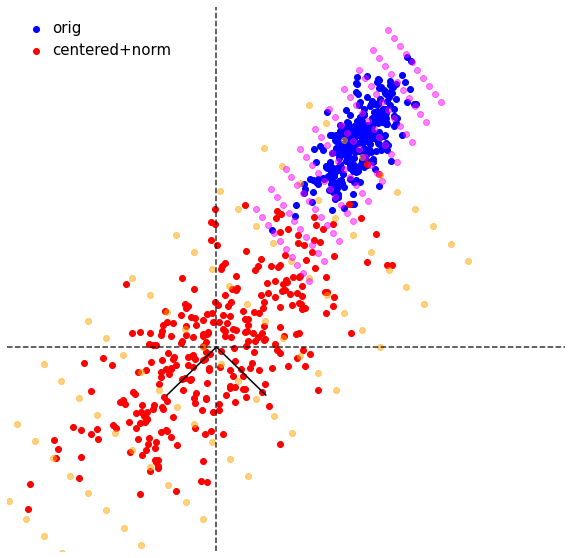

In [13]:
fig = plt.figure(figsize=(10,10))
x = np.random.randn(300)/3 + 2
y = np.random.randn(300)/3 + x +1
data = np.array([x,y]).T
plt.scatter(data[:,0],data[:,1],color='blue',label='orig')

data_mean = np.mean(data, axis=0)
data_std = np.std(data, axis=0)
centered_data = (data - data_mean) / data_std
plt.scatter(centered_data[:,0],centered_data[:,1],color='red',label='centered+norm')

pca = PCA(n_components=2)
pca.fit(centered_data)
cdata_pca = pca.transform(centered_data)

num_points = 10
PC1 = cdata_pca[:,0]
PC2 = cdata_pca[:,1]

PC1_range = np.linspace(np.min(PC1), np.max(PC1), num_points)
PC2_range = np.linspace(np.min(PC2), np.max(PC2), num_points)

PC1_mesh, PC2_mesh = np.meshgrid(PC1_range,PC2_range)

# Convert PC coordinates into full weight vectors
flat_PC1_vals = PC1_mesh.reshape(1,num_points**2)
flat_PC2_vals = PC2_mesh.reshape(1,num_points**2)
meshgrid_points = np.concatenate([flat_PC1_vals,flat_PC2_vals]).T
gridpoints_weightspace = pca.inverse_transform(meshgrid_points)


# PC1_range = np.expand_dims(PC1_range,1)
# gridpoints_weightspace = pca.inverse_transform(PC1_range)

plt.scatter(gridpoints_weightspace[:,0],gridpoints_weightspace[:,1],color='orange',alpha=0.5)

grid = gridpoints_weightspace * data_std + data_mean
plt.scatter(grid[:,0],grid[:,1],color='magenta',alpha=0.5)

plt.plot([0,pca.components_[0,0]],[0,pca.components_[0,1]],color='black')
plt.plot([0,pca.components_[1,0]],[0,pca.components_[1,1]],color='black')

# Plot axis lines
plt.plot([0,0],[-3,5],'--',color='k',alpha=0.8)
plt.plot([-3,5],[0,0],'--',color='k',alpha=0.8)
plt.xlim([-3,5])
plt.ylim([-3,5])
plt.legend()
plt.axis('off')
plt.show()


In [14]:
pca.components_

array([[-0.70710678, -0.70710678],
       [ 0.70710678, -0.70710678]])

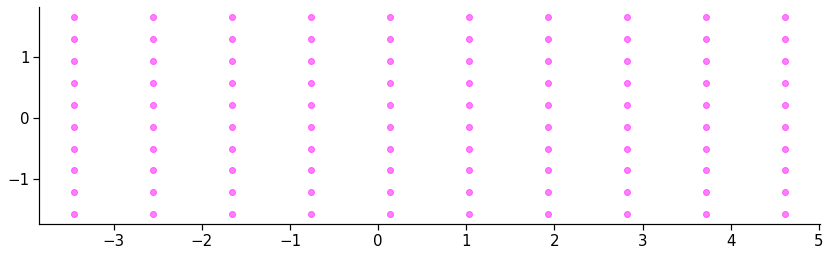

In [15]:
plt.scatter(meshgrid_points[:,0],meshgrid_points[:,1],color='magenta',alpha=0.5)
